In [1]:
from geometry import Polygon, Point, Line
from plot import Map
import geopandas as gpd
import pandas as pd
import numpy as np

In [7]:
poly1 = Polygon(origin=(0, 0), size=(2,2), data={"FIPS": "08031", "NAME": "place1"})
point = Point(coords=(3, 5), data={"FIPS": "08031", "NAME": "fs1"})
mpoly = Polygon(origin=(0, 0), size=(10, 10), data={"FIPS": "08031", "NAME": "place1"}).split_grid(2, 2)
line = Line(coords=[(0,0), (3,3), (5,8)], data={"FIPS": "08031", "NAME": "line1"})


mpoly_gdf = gpd.GeoDataFrame()
for poly in mpoly:
    mpoly_gdf = pd.concat([mpoly_gdf, poly.to_gdf()], ignore_index=True)
mpoly_gdf['NAME'] = 'grid_cell'
mpoly_gdf.loc[0, 'NAME'] = 'cell1'
mpoly_gdf.loc[1, 'NAME'] = 'cell2'
mpoly_gdf.loc[2, 'NAME'] = 'cell3'
mpoly_gdf.loc[3, 'NAME'] = 'cell4'



In [8]:

m = Map(title='Test Map', figsize=(30, 10))
m.add_shape(
    poly1, 
    layer='Place', 
    style={"facecolor": "blue", "edgecolor": 'red', "alpha": 0.5}, 
    label='FIPS',
)
m.add_shape(
    point, 
    layer='FireStations', 
    style={"color": "red", "edgecolor": "black"}, 
    label='NAME'
    )

m.add_gdf(
    
    mpoly_gdf, 
    layer='Grid', 
    style={"facecolor": "yellow", "edgecolor": 'black', "alpha": 0.3}, 
    label='NAME'
)

m.add_shape(
    line, 
    layer='A Line', 
    style={"color": "green", "linewidth": 2}, 
    label='NAME'
)
m.layers

{'Place': {'shapes': [{'source': 'shape',
    'data': Polygon(coords=[(0, 0), (2, 0), (2, 2), (0, 2)], data={'FIPS': '08031', 'NAME': 'place1'}, origin=(0, 0), size=(2, 2), interior=None, geometry=<POLYGON ((0 0, 2 0, 2 2, 0 2, 0 0))>),
    'label': 'FIPS',
    'label_kwargs': {}}],
  'style': {'facecolor': 'blue', 'edgecolor': 'red', 'alpha': 0.5}},
 'FireStations': {'shapes': [{'source': 'shape',
    'data': Point(coords=(3, 5), data={'FIPS': '08031', 'NAME': 'fs1'}, geometry=<POINT (3 5)>),
    'label': 'NAME',
    'label_kwargs': {}}],
  'style': {'color': 'red', 'edgecolor': 'black'}},
 'Grid': {'shapes': [{'source': 'gdf',
    'data':                                   geometry   NAME
    0      POLYGON ((0 0, 5 0, 5 5, 0 5, 0 0))  cell1
    1    POLYGON ((5 0, 10 0, 10 5, 5 5, 5 0))  cell2
    2    POLYGON ((0 5, 5 5, 5 10, 0 10, 0 5))  cell3
    3  POLYGON ((5 5, 10 5, 10 10, 5 10, 5 5))  cell4,
    'label': 'NAME',
    'label_kwargs': {}}],
  'style': {'facecolor': 'yellow', 'e

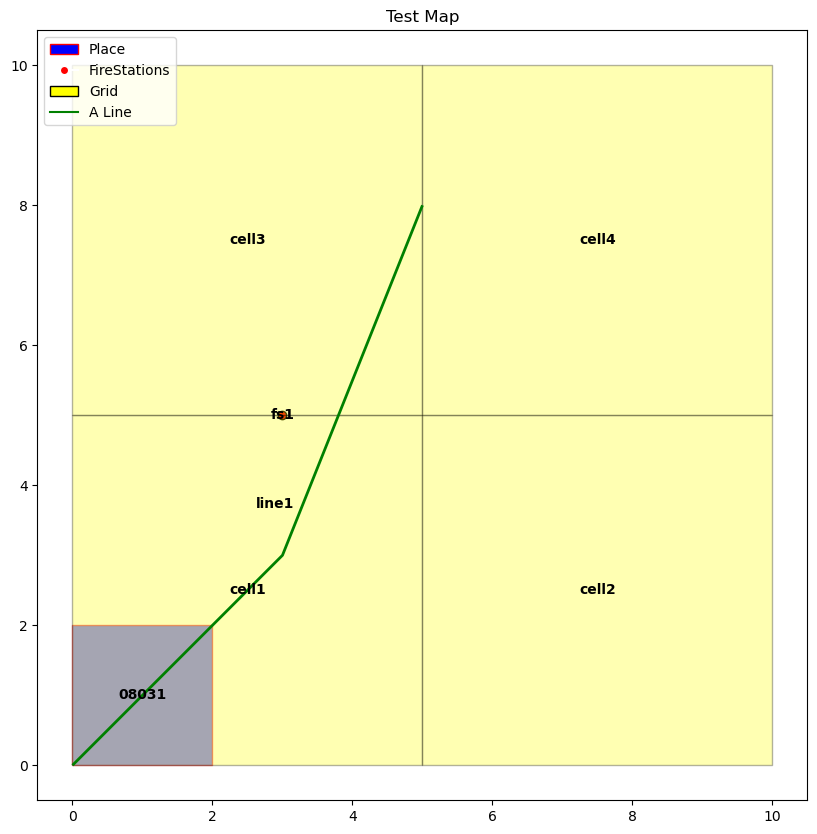

In [9]:
m.plot()